Train Data: (26938, 5), Validation Data: (8980, 5), Test Data: (8980, 5)
Epoch 1/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 68s 153ms/step - accuracy: 0.8448 - loss: 2348.9673 - val_accuracy: 0.9112 - val_loss: 0.2169
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 65s 154ms/step - accuracy: 0.9377 - loss: 0.2501 - val_accuracy: 0.9160 - val_loss: 0.1904
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 65s 154ms/step - accuracy: 0.9523 - loss: 0.1193 - val_accuracy: 0.9179 - val_loss: 0.1783
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - accuracy: 0.9646 - loss: 0.0940 - val_accuracy: 0.9277 - val_loss: 0.1749
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 63s 150ms/step - accuracy: 0.9750 - loss: 0.1200 - val_accuracy: 0.9253 - val_loss: 0.1791
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 64s 152ms/step - accuracy: 0.9729 - loss: 1.0210 - val_accuracy: 0.9273 - val_loss: 0.1754
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.9797 - loss: 0.0674 - val_accuracy: 0.9280 - val_loss: 0.1758


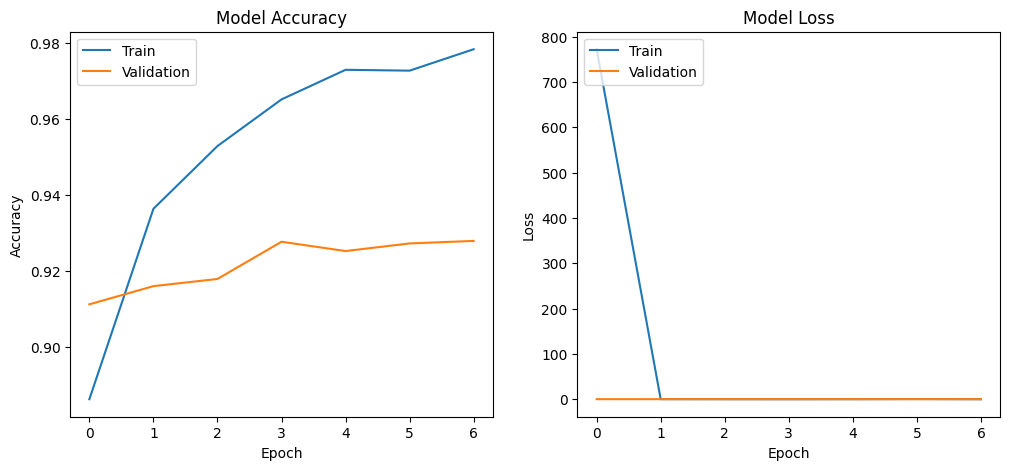

281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
Accuracy: 93.03%
Precision: 0.9217
Recall: 0.9472
F1 Score: 0.9343

Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.91      0.93      4284
        Fake       0.92      0.95      0.93      4696

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



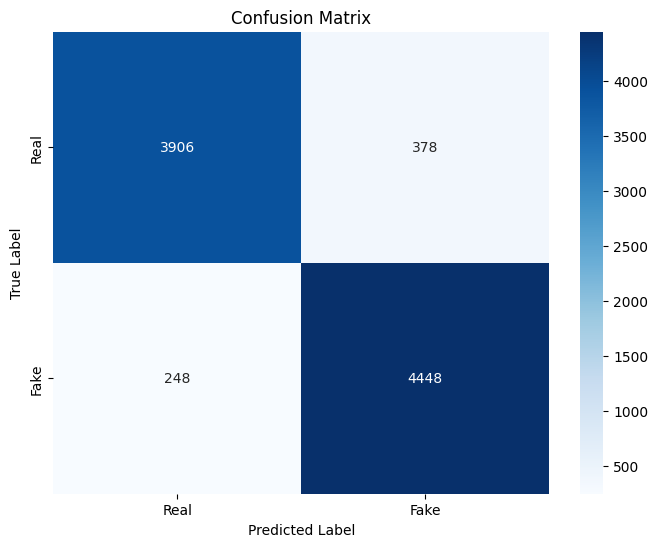

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import lime
import lime.lime_text
import shap


negative_df = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")
negative_df["fake"] = 0  
positive_df = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
positive_df["fake"] = 1  


train_df = pd.concat([negative_df, positive_df]).sample(frac=1, random_state=42)  


train_data, temp_data = train_test_split(train_df, test_size=0.4, stratify=train_df["fake"], random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data["fake"], random_state=42)


print(f"Train Data: {train_data.shape}, Validation Data: {valid_data.shape}, Test Data: {test_data.shape}")


def create_dataset(dataframe, shuffle=True, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"].values, dataframe["fake"].values))
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)
test_ds = create_dataset(test_data, shuffle=False)


max_words = 10000  
max_sequence_length = 100  

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["text"])

def tokenize_data(dataframe):
    sequences = tokenizer.texts_to_sequences(dataframe["text"])
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

X_train_pad = tokenize_data(train_data)
X_valid_pad = tokenize_data(valid_data)
X_test_pad = tokenize_data(test_data)
y_train = train_data["fake"].values
y_valid = valid_data["fake"].values
y_test = test_data["fake"].values


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=128),
    tf.keras.layers.SpatialDropout1D(0.2),  
    tf.keras.layers.GRU(100, dropout=0.2, recurrent_dropout=0.2),  
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train_pad, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_valid_pad, y_valid),
    callbacks=[early_stopping]
)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


y_pred = model.predict(X_test_pad)
y_pred_binary = (y_pred > 0.5).flatten() 


accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_test, y_pred_binary)
accuracy_value = accuracy.result().numpy()


precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)


print(f'Accuracy: {accuracy_value * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


print('\nClassification Report:')
print(classification_report(y_test, y_pred_binary, target_names=["Real", "Fake"]))


cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()





   


Explaining predictions with LIME:
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step
True label: Real
LIME explanation:
  Tuesday: -0.09705085774159855
  reported: -0.03809855877896206
  the: 0.021535326723354373
  noon: 0.018607749358492468
  levels: -0.011813212626670436
  at: 0.011161017633156817


<Figure size 1000x600 with 0 Axes>

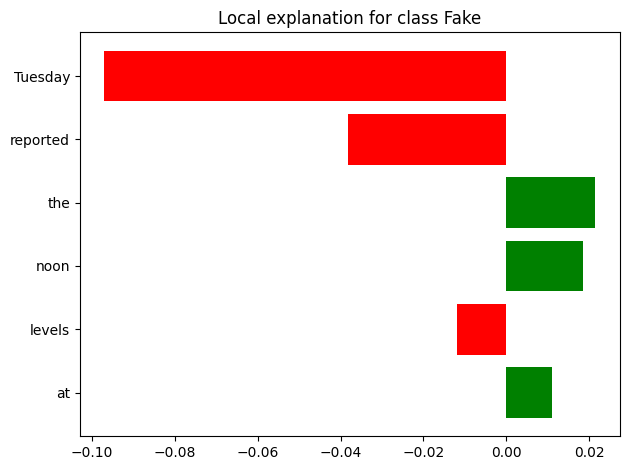

In [3]:

print("\nExplaining predictions with LIME:")
explainer = lime.lime_text.LimeTextExplainer(class_names=["Real", "Fake"])


def predict_proba(texts):

    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)
   
    preds = model.predict(padded)
    
    return np.hstack([1-preds, preds])


def find_suitable_example(max_attempts=10):
    """Find an example with enough tokens for LIME to analyze."""
    for _ in range(max_attempts):
        idx = np.random.randint(0, len(test_data))
        text = test_data["text"].iloc[idx]
        true_label = test_data["fake"].iloc[idx]
        
        
        sequence = tokenizer.texts_to_sequences([text])[0]
        if len(sequence) >= 10:  
            return idx, text, true_label
    
   
    for idx in range(min(100, len(test_data))):
        text = test_data["text"].iloc[idx]
        true_label = test_data["fake"].iloc[idx]
        sequence = tokenizer.texts_to_sequences([text])[0]
        if len(sequence) >= 10:
            return idx, text, true_label
    
    
    return 0, test_data["text"].iloc[0], test_data["fake"].iloc[0]


idx, text, true_label = find_suitable_example()


max_words_for_lime = 1000
text_words = text.split()
if len(text_words) > max_words_for_lime:
    text = ' '.join(text_words[:max_words_for_lime])
    print(f"Note: Text was trimmed to {max_words_for_lime} words for LIME analysis")

try:
    
    exp = explainer.explain_instance(text, predict_proba, num_features=6)
    print(f"True label: {'Fake' if true_label == 1 else 'Real'}")
    print("LIME explanation:")
    for word, weight in exp.as_list():
        print(f"  {word}: {weight}")

    
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"LIME explanation failed: {e}")
    print("The text might be too short, too long, or contain words that the model doesn't recognize.")


Initializing SHAP explainer (this may take a while)...
Computing SHAP values for 5 examples...
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step


PermutationExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


PermutationExplainer explainer:  60%|██████    | 3/5 [01:01<00:32, 16.06s/it]

310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


PermutationExplainer explainer:  80%|████████  | 4/5 [01:34<00:23, 23.12s/it]

312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step


PermutationExplainer explainer: 100%|██████████| 5/5 [02:07<00:00, 26.78s/it]

312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step


PermutationExplainer explainer: 6it [02:40, 32.10s/it]                       


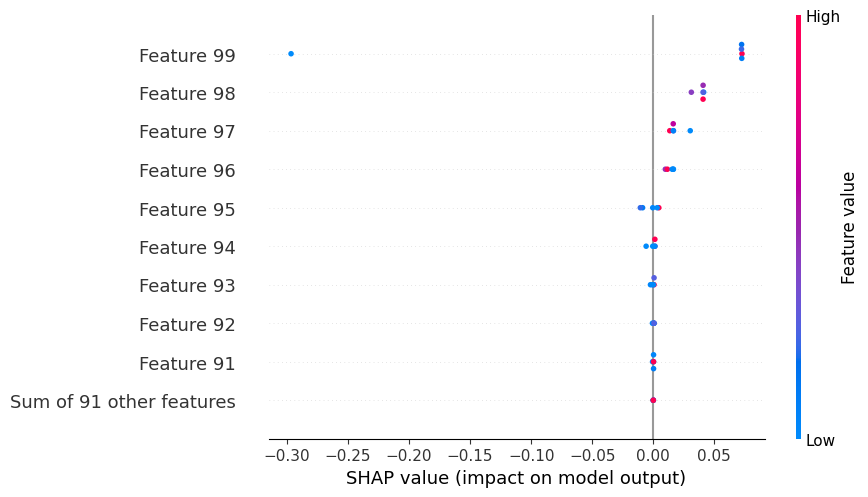

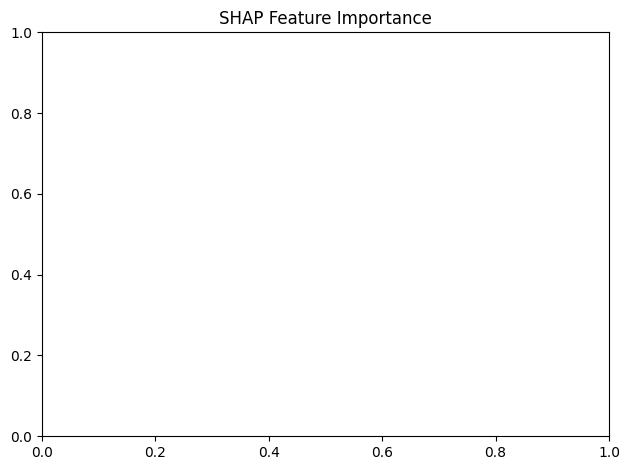


Detailed SHAP explanation for Fake news example:


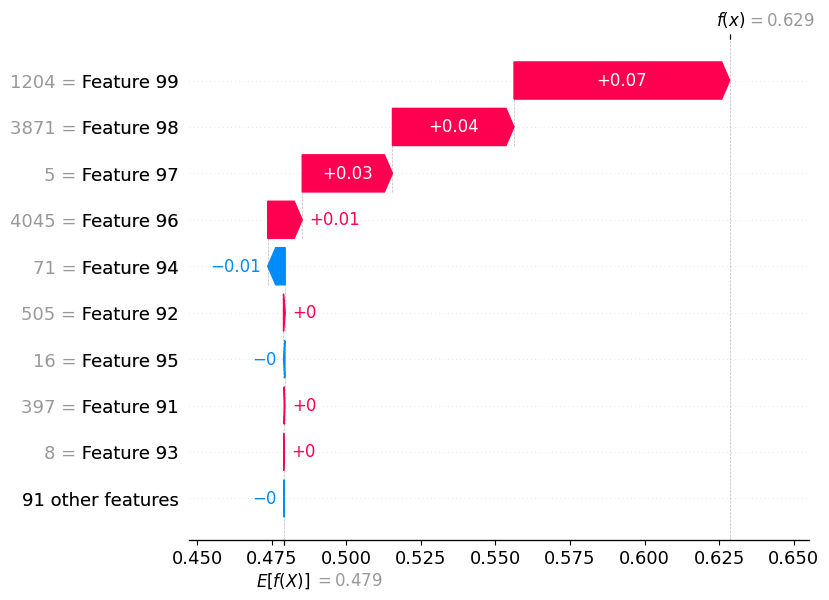

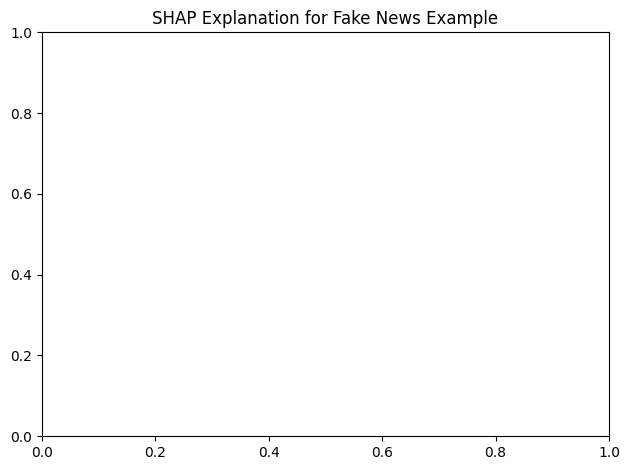


Model and interpretability analysis completed!


In [4]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle


def text_to_input(texts):
    if isinstance(texts, np.ndarray):  
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]
    
   
    texts = [str(text) for text in texts]  
    
    sequences = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

def model_predict(texts):
    inputs = text_to_input(texts)
    return model.predict(inputs).flatten()


background_size = 50
background_indices = np.random.choice(len(test_data), background_size, replace=False)
background_texts = test_data['text'].iloc[background_indices].tolist()
background_inputs = text_to_input(background_texts)  # Ensure correct input format


print("\nInitializing SHAP explainer (this may take a while)...")
explainer = shap.Explainer(model_predict, background_inputs)


n_examples = 5
sample_indices = np.random.choice(len(test_data), n_examples, replace=False)
sample_texts = test_data['text'].iloc[sample_indices].tolist()
sample_inputs = text_to_input(sample_texts)  
sample_labels = test_data['fake'].iloc[sample_indices].tolist()

print(f"Computing SHAP values for {n_examples} examples...")
shap_values = explainer(sample_inputs)


plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()


example_idx = 0
print(f"\nDetailed SHAP explanation for {'Fake' if sample_labels[example_idx] == 1 else 'Real'} news example:")
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap_values[example_idx])
plt.title(f"SHAP Explanation for {'Fake' if sample_labels[example_idx] == 1 else 'Real'} News Example")
plt.tight_layout()
plt.show()


model.save('gru_fake_news_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nModel and interpretability analysis completed!")

In [5]:

y_pred_binary = y_pred_binary.flatten()
y_test = y_test.flatten()


misclassified_df = pd.DataFrame({
    'Text Snippet': test_data['text'].values,
    'True Label': ['Fake' if label == 1 else 'Real' for label in y_test],
    'Predicted Label': ['Fake' if pred == 1 else 'Real' for pred in y_pred_binary]
})


misclassified_df = misclassified_df[misclassified_df['True Label'] != misclassified_df['Predicted Label']]


misclassified_df["Comment"] = ""


print(misclassified_df.head(5))


misclassified_df.to_csv("misclassified_examples.csv", index=False)


                                         Text Snippet True Label  \
3   LOS ANGELES (Reuters) - Democratic lawmakers i...       Real   
13  CNN cut away from a Senate Judiciary Committee...       Fake   
37  Pastor Kenneth Sharpton Glasgow claims he s Re...       Fake   
47  PARIS (Reuters) - Corsican nationalists won al...       Real   
54  ROME (Reuters) - The European Union wants Brit...       Real   

   Predicted Label Comment  
3             Fake          
13            Real          
37            Real          
47            Fake          
54            Fake          
